In [68]:
import torch
import torchaudio
import time
from typing import List

import IPython
import matplotlib.pyplot as plt
from torchaudio.models.decoder import ctc_decoder
from torchaudio.utils import download_asset

from blank_collapse import blank_collapse

In [3]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_10M
acoustic_model = bundle.get_model()

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ll10m.pth" to /Users/user/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ll10m.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

In [4]:
speech_file = download_asset("tutorial-assets/ctc-decoding/1688-142285-0007.wav")

IPython.display.Audio(speech_file)

  0%|          | 0.00/441k [00:00<?, ?B/s]

In [5]:
waveform, sample_rate = torchaudio.load(speech_file)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [6]:
tokens = [label.lower() for label in bundle.get_labels()]
print(tokens)

['-', '|', 'e', 't', 'a', 'o', 'n', 'i', 'h', 's', 'r', 'd', 'l', 'u', 'm', 'w', 'c', 'f', 'g', 'y', 'p', 'b', 'v', 'k', "'", 'x', 'j', 'q', 'z']


In [7]:
from torchaudio.models.decoder import download_pretrained_files

files = download_pretrained_files("librispeech-4-gram")

  0%|          | 0.00/4.97M [00:00<?, ?B/s]

  0%|          | 0.00/57.0 [00:00<?, ?B/s]

  0%|          | 0.00/2.91G [00:00<?, ?B/s]

In [10]:
LM_WEIGHT = 3.23
WORD_SCORE = -0.26

beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=files.tokens,
    lm=files.lm,
    nbest=3,
    beam_size=1500,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

In [11]:
actual_transcript = "i really was very much afraid of showing him how much shocked i was at some parts of what he said"
actual_transcript = actual_transcript.split()

In [12]:
beam_search_result = beam_search_decoder(emission)
beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()
beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, beam_search_result[0][0].words) / len(
    actual_transcript
)

print(f"Transcript: {beam_search_transcript}")
print(f"WER: {beam_search_wer}")

Transcript: i really was very much afraid of showing him how much shocked i was at some part of what he said
WER: 0.047619047619047616


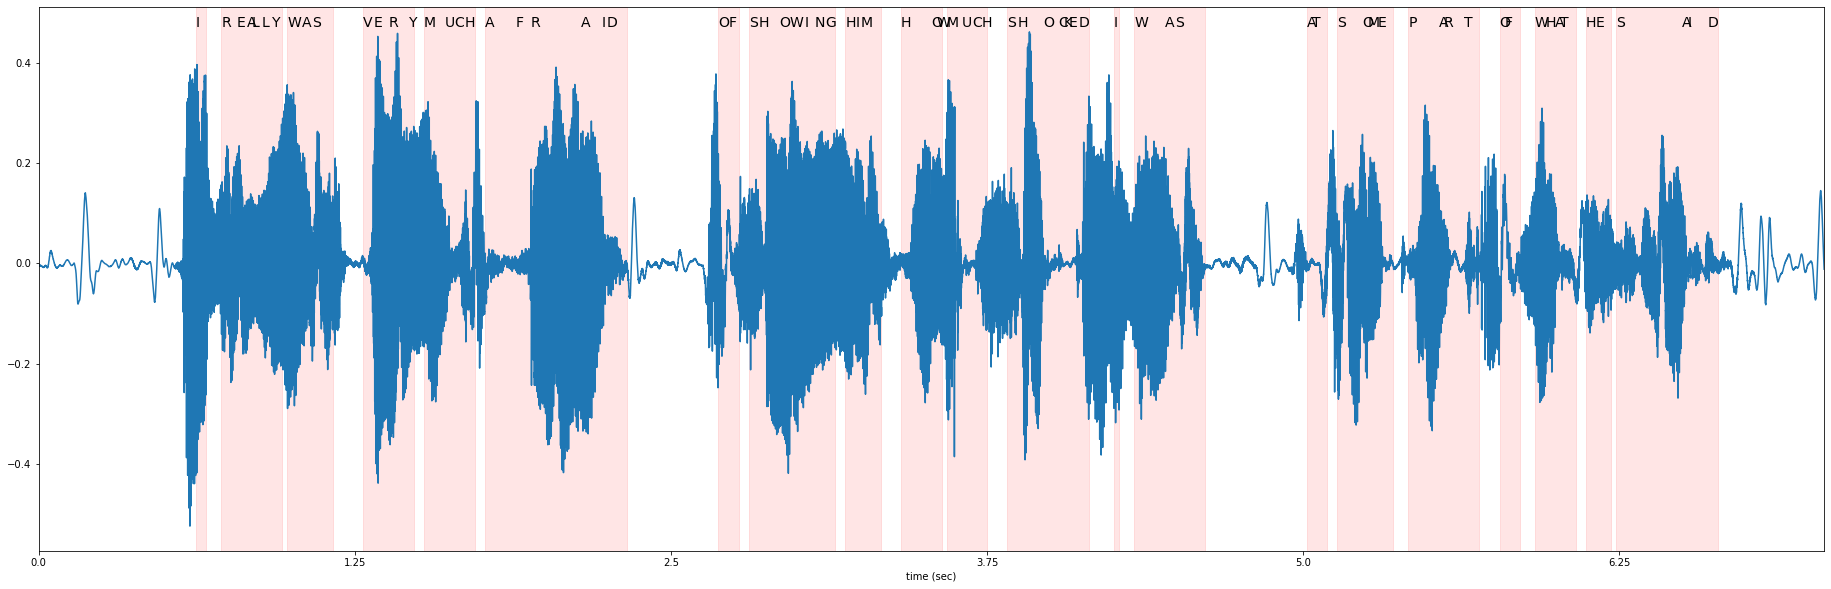

In [15]:
def plot_alignments(waveform, emission, tokens, timesteps):
    fig, ax = plt.subplots(figsize=(32, 10))

    ax.plot(waveform)

    ratio = waveform.shape[0] / emission.shape[1]
    word_start = 0

    for i in range(len(tokens)):
        if i != 0 and tokens[i - 1] == "|":
            word_start = timesteps[i]
        if tokens[i] != "|":
            plt.annotate(tokens[i].upper(), (timesteps[i] * ratio, waveform.max() * 1.02), size=14)
        elif i != 0:
            word_end = timesteps[i]
            ax.axvspan(word_start * ratio, word_end * ratio, alpha=0.1, color="red")

    xticks = ax.get_xticks()
    plt.xticks(xticks, xticks / bundle.sample_rate)
    ax.set_xlabel("time (sec)")
    ax.set_xlim(0, waveform.shape[0])


In [95]:
def print_decoded(decoder, emission, param, param_value):
    start_time = time.monotonic()
    result = decoder(emission)
    decode_time = time.monotonic() - start_time

    transcript = " ".join(result[0][0].words).lower().strip()
    beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, beam_search_result[0][0].words) / len(
        actual_transcript
    )
    score = result[0][0].score
    print(f"{param} {param_value:.4f}: {transcript} (wer: {beam_search_wer:.4f}); (score: {score:.2f}; {decode_time:.4f} secs)")

    return result[0][0]

blank_threshold 1.0000: i really was very much afraid of showing him how much shocked i was at some part of what he said (wer: 0.0476); (score: 3699.82; 1.0249 secs)
blank_threshold 0.9990: i really was very much afraid of showing him how much shocked i was at some part of what he said (wer: 0.0476); (score: 2658.90; 0.8875 secs)
blank_threshold 0.9900: i really was very much afraid of showing him how much shocked i was at some part of what he said (wer: 0.0476); (score: 2549.33; 0.8880 secs)
blank_threshold 0.9000: i really was very much afraid of showing him how much shocked i was at some part of what he said (wer: 0.0476); (score: 2464.14; 0.8524 secs)
blank_threshold 0.5000: i really was very much afraid of showing him how much shocked i was at some part of what he said (wer: 0.0476); (score: 2364.72; 0.7919 secs)


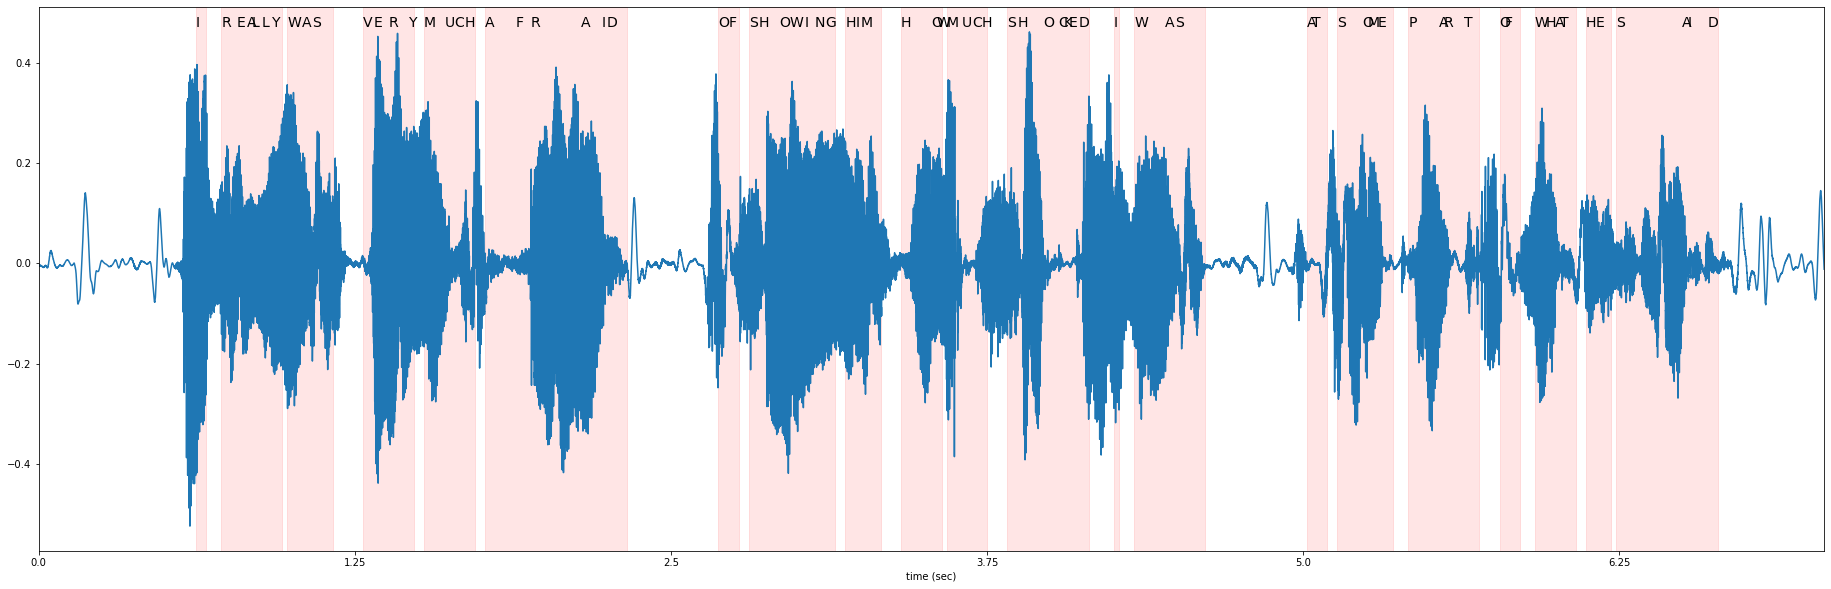

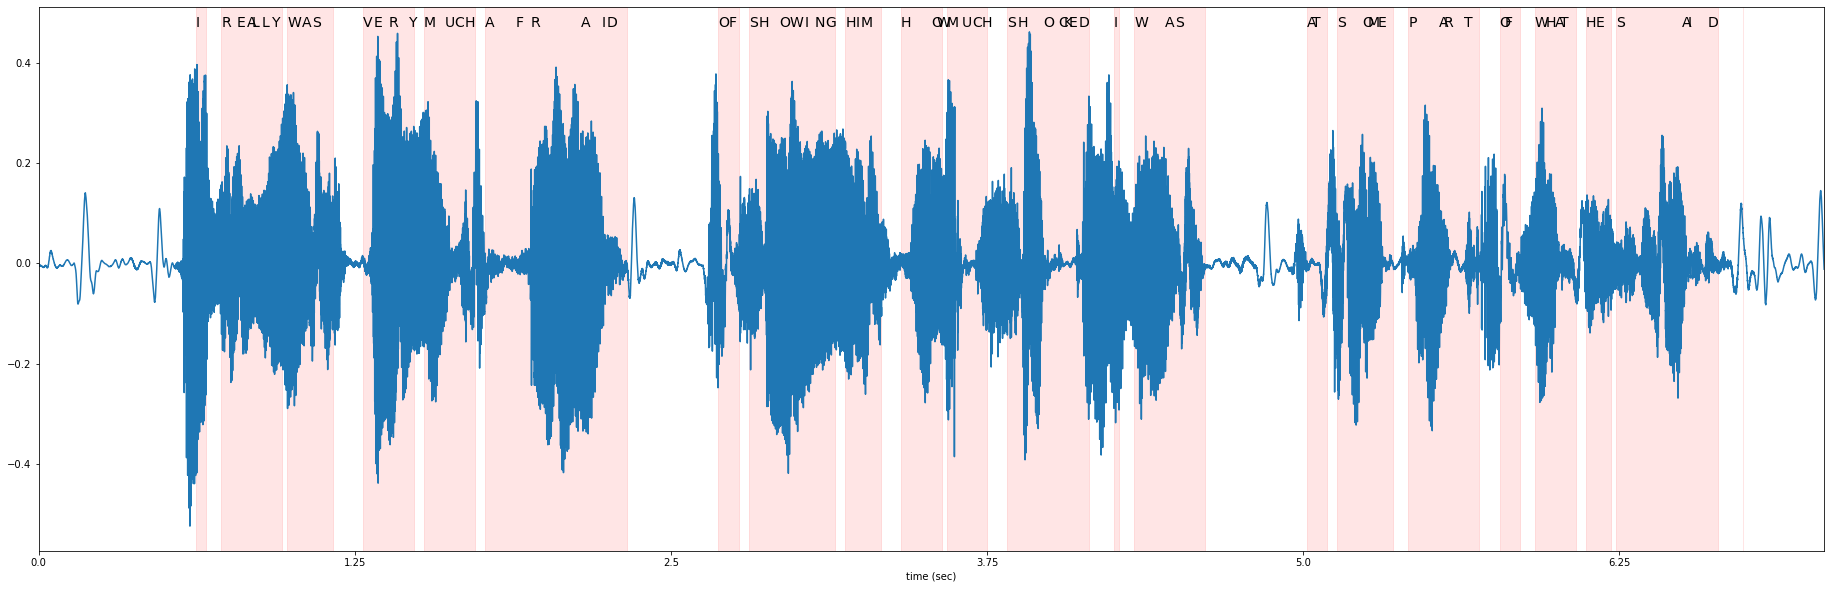

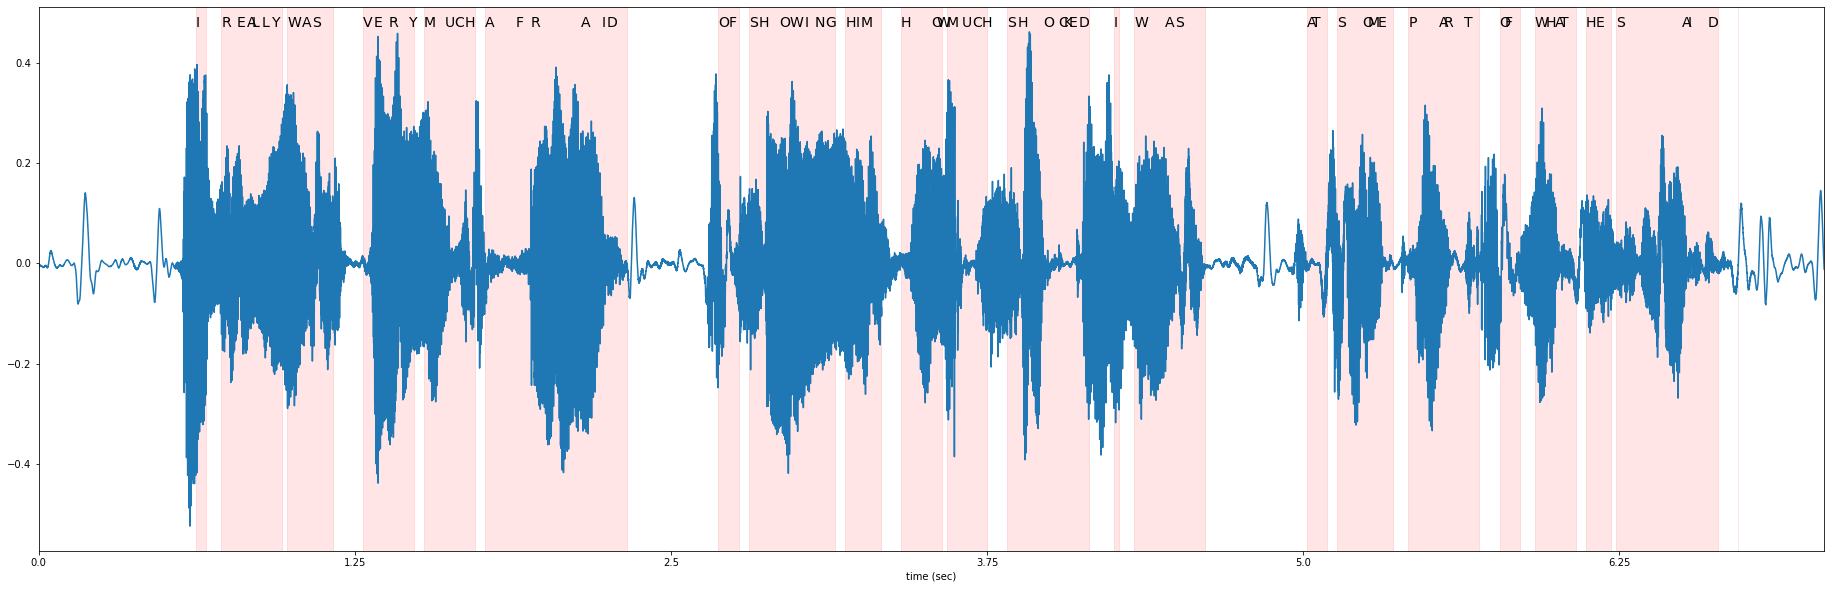

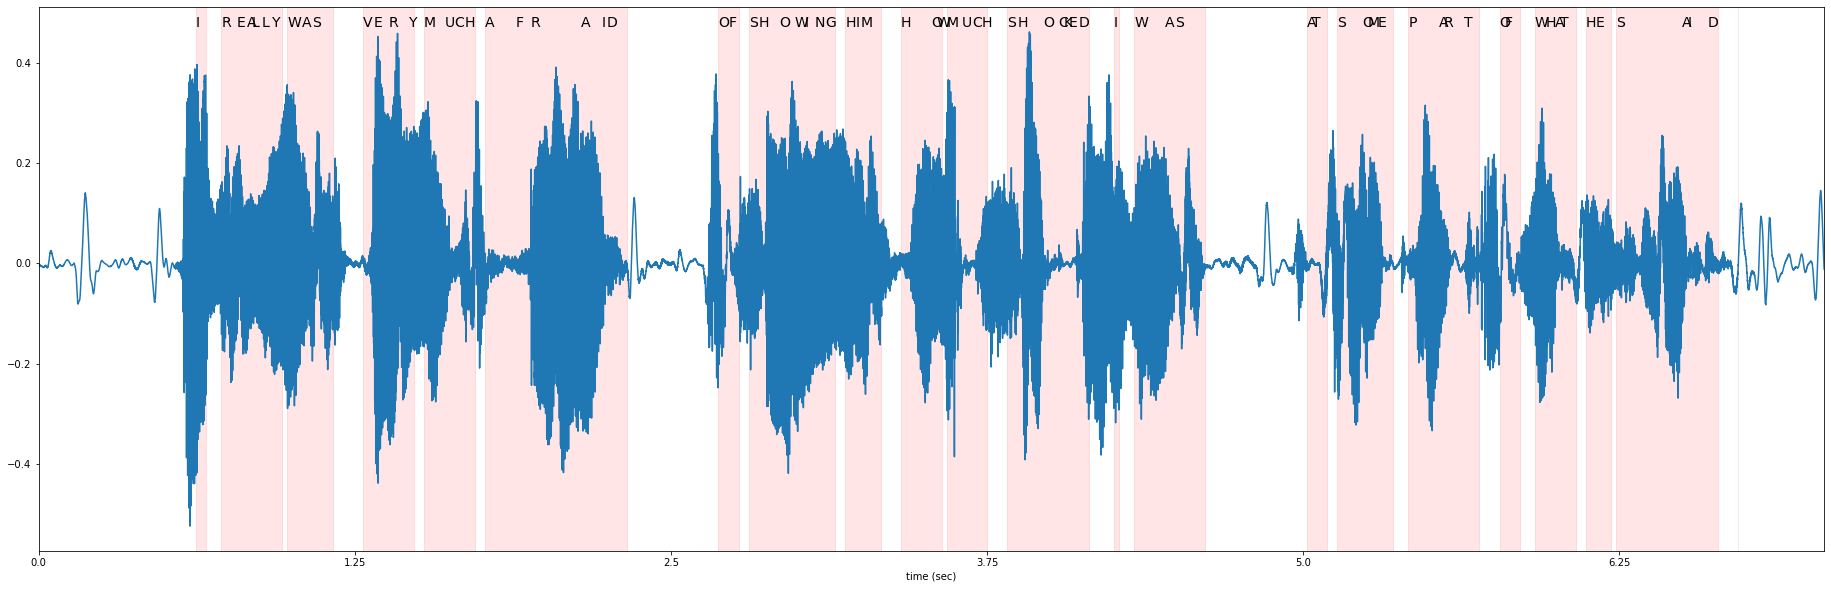

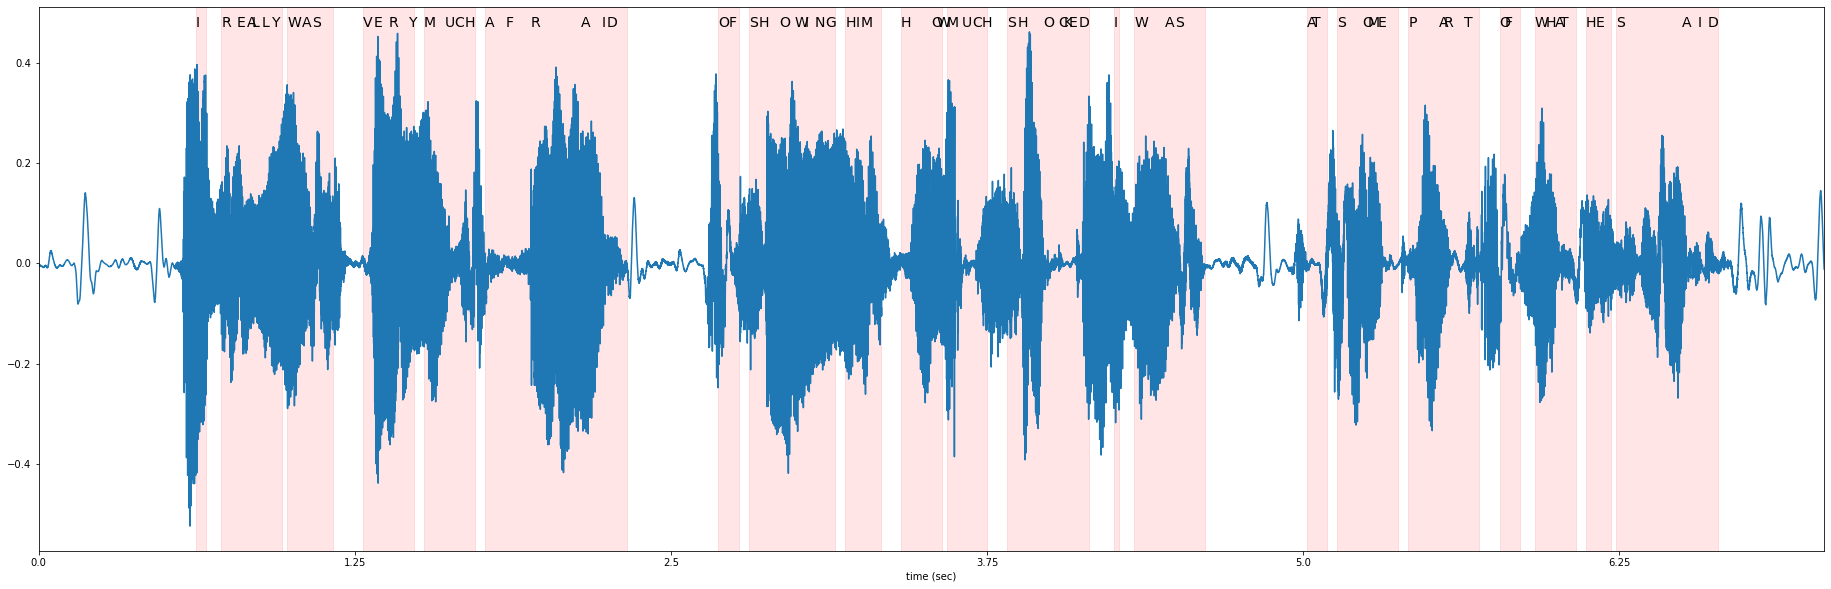

In [98]:
BEAM_SIZE = 1500
blank_thresholds = [1, 0.999, 0.99, 0.9, 0.5]
beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=files.tokens,
    lm=files.lm,
    beam_size=BEAM_SIZE,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

emission, _ = acoustic_model(waveform)
for blank_threshold in blank_thresholds:
    new_emission = emission
    if blank_threshold < 1:
        collapsed, org_timesteps = blank_collapse(emission[0], blank_threshold, 0)
        new_emission = collapsed[None, :]

    result = print_decoded(beam_search_decoder, new_emission, "blank_threshold", blank_threshold)
    if blank_threshold < 1:
        timesteps = [org_timesteps[t] if t < len(org_timesteps) else org_timesteps[-1] for t in result.timesteps]
    else:
        timesteps = result.timesteps
    predicted_tokens = beam_search_decoder.idxs_to_tokens(result.tokens)
    
    plot_alignments(waveform[0], emission, predicted_tokens, timesteps)